# 的を正面から見た感じにする

### 手順の確認  
1. 的を囲む四角い板を検出
2. その板を正面から見た様に変形  
3. 開いた穴を認識する

問題は写真の中から板をどうやって検出するか。  
=> 複数のフィルターをかけて最大面積を検出すれば良い

In [85]:
# -*- coding:utf-8 -*-
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [108]:
# グレースケール画像の準備
img        = cv2.imread('data/target6.jpg')
img_blur   = cv2.GaussianBlur(img, (5,5), 0)
img_gray   = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
th, img_bi = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY)

### RGB

In [87]:
def get_th_rgb(img,r1,g1,b1,r2,g2,b2):
    img_rgb = img.copy()                            # rgbスケール
    rgb_min = np.array([r1,g1,b1], np.uint8)
    rgb_max = np.array([r2,g2,b2], np.uint8)
    th      = cv2.inRange(img_rgb, rgb_min, rgb_max)
    return th

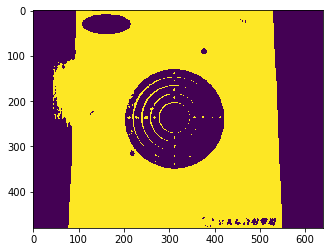

In [88]:
th1 = get_th_rgb(img_blur,100,100,100,255,255,255)
plt.imshow(th1)

### HSV

In [89]:
def get_th_hsv(img,h1,s1,v1,h2,s2,v2):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  # hsvスケール
    hsv_min = np.array([h1,s1,v1], np.uint8)
    hsv_max = np.array([h2,s2,v2], np.uint8)
    th      = cv2.inRange(img_hsv, hsv_min, hsv_max)
    return th

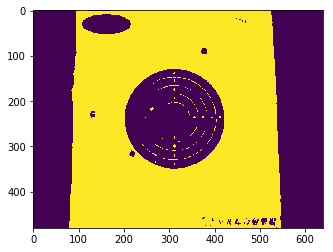

In [90]:
th2 = get_th_hsv(img_blur,0,0,100,200,35,255)
plt.imshow(th2)

### 適応的閾値処理

In [91]:
def get_th_ad1(img_gray, Block_Size, C):
    th = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, Block_Size, C) # ブロック数, 引く数
    return th

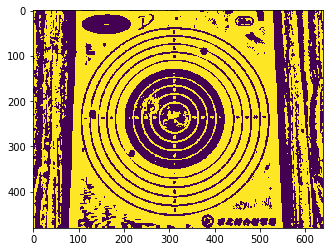

In [109]:
th3 = get_th_ad1(img_gray, 39, 1)
plt.imshow(th3)

In [93]:
def get_th_ad2(img_gray, Block_Size, C):
    th = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, Block_Size, C)
    return th

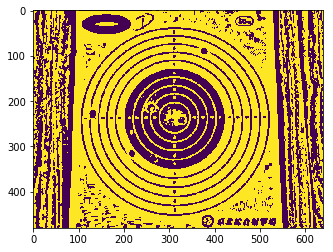

In [94]:
th4 = get_th_ad2(img_gray, 39, 1)
plt.imshow(th4)

### 合成フィルター

In [95]:
def get_th(img):
    # グレースケール画像の準備
    img_blur   = cv2.GaussianBlur(img, (5,5), 0)
    img_gray   = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    
    th1 = get_th_rgb(img_blur,100,100,100,255,255,255) # rgb
    th2 = get_th_hsv(img_blur,0,0,100,200,35,255)      # hsv
    th3 = get_th_ad1(img_gray,39,1)                    # ad1
    th4 = get_th_ad2(img_gray,39,1)                    # ad2

    th = cv2.bitwise_and(th1,th2)
    th = cv2.bitwise_and(th, th3)
    th = cv2.bitwise_and(th, th4)
    return th

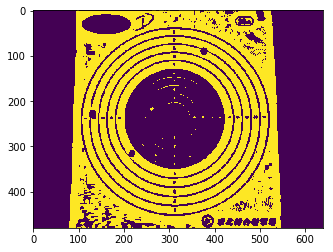

In [96]:
th = get_th(img)
plt.imshow(th)

## 最大面積の取得

In [97]:
def get_contours(th):
    _, contours, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [98]:
def get_max_cnt(th):
    # 輪郭を取得
    contours = get_contours(th)
    if(len(contours)==0):
        width,height = th.shape
        return np.array([[[0,0]],[[0,width]],[[height,width]],[[height,0]]])
    
    # 最大輪郭を取得
    cnt_list = np.array([cv2.moments(cnt)['m00'] for cnt in contours]) # 各cntの面積リスト
    index    = np.argmax(cnt_list)  # 面積最大の指標
    max_cnt  = contours[index]      # 最大cntを取得
    
    # 最大輪郭の近似(滑らかにする)
    epsilon = 0.1*cv2.arcLength(max_cnt,True)
    max_cnt = cv2.approxPolyDP(max_cnt,epsilon,True)
    return max_cnt

総輪郭数: 18
最大頂点数: 4
最大頂点: [97  1],[ 80 479],[547 479],[525   0]


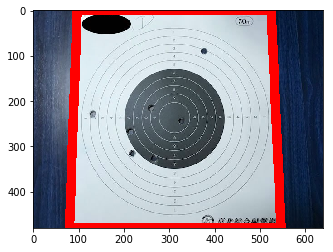

In [99]:
contours = get_contours(th)
cnt      = get_max_cnt(th)
print("総輪郭数: {}".format(len(contours)))
print("最大頂点数: {}".format(len(cnt)))
print("最大頂点: {},{},{},{}".format(cnt[0,0],cnt[1,0],cnt[2,0],cnt[3,0]))
img_cnt = cv2.drawContours(img.copy(), [cnt], 0, (255,0,0), 20)
plt.imshow(img_cnt)

## 斜めから正面に変換

In [100]:
def get_target(img,cnt):
    if(len(cnt)==4):
        # 頂点座標の整理
        cnt = cnt.tolist()
        cnt.sort(key=lambda x:x[0][0]+x[0][1])
        cnt = np.array(cnt)
        # 切り出し箇所
        pts1 = np.float32([[cnt[0,0,0],cnt[0,0,1]],  # 左上点
                           [cnt[1,0,0],cnt[1,0,1]],  # 右上点
                           [cnt[2,0,0],cnt[2,0,1]],  # 左下点
                           [cnt[3,0,0],cnt[3,0,1]]]) # 右下点
        pts2 = np.float32([[0,0],[0,300],[300,0],[300,300]]) # 切り出し後サイズ
        M = cv2.getPerspectiveTransform(pts1,pts2)
        dst = cv2.warpPerspective(img,M,(300,300))
        return dst
    else:
        return np.zeros((300,300))

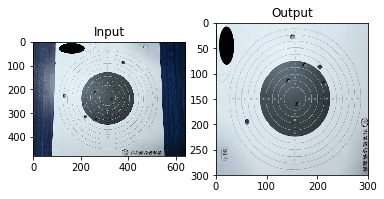

In [101]:
target = get_target(img,cnt)
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(target),plt.title('Output')
plt.show()

## 穴の位置を特定
複数の検出法を調べないと  
二値化してテンプレートマッチングとか  
[穴検出](http://blog.sigbus.info/2011/11/opencv.html)

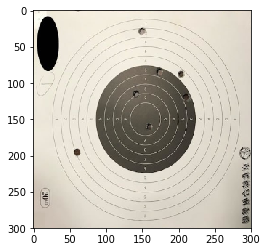

In [102]:
plt.imshow(cv2.cvtColor(target,cv2.COLOR_BGR2RGB))

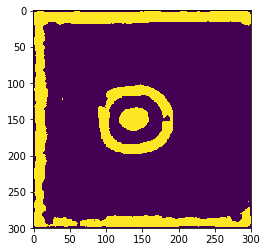

In [107]:
target_gray = cv2.cvtColor(target,cv2.COLOR_BGR2GRAY)
th5 = get_th_ad1(target_gray,39,-10)
plt.imshow(th5)

## Webカメラで実行

In [120]:
# 0 => IVcan, 1 => Webカメラ
cap = cv2.VideoCapture(1)

while True:
    ret, img = cap.read()          # フレームの読み込み
    th       = get_th(img)         # 白っぽい部分を取得
    cnt      = get_max_cnt(th)     # 最大部分を囲む矩形
    target   = get_target(img,cnt) # 的の板を正面にする
    img_rect = cv2.drawContours(img.copy(), [cnt], 0, (255,0,0), 12)
    
    # 画像を表示する
    cv2.imshow('th', th)
    cv2.imshow('img_rect', img_rect)
    cv2.imshow('target', target)

    # キー入力を1ms待って、kが27(Esc)だったらbreakする
    k = cv2.waitKey(1)
    if k == 27:
        break

# キャプチャをリリースして、ウィンドウを全て閉じる
cap.release()
cv2.destroyAllWindows()

In [119]:
def get_th(img):
    # グレースケール画像の準備
    img_blur   = cv2.GaussianBlur(img, (5,5), 0)
    img_gray   = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    
    th1 = get_th_rgb(img_blur,100,100,100,255,255,255) # rgb
    th2 = get_th_hsv(img_blur,0,0,100,150,35,255)      # hsv
    th3 = get_th_ad1(img_gray,9,1)                    # ad1
    th4 = get_th_ad2(img_gray,9,1)                    # ad2

    th = cv2.bitwise_and(th1,th2)
    th = cv2.bitwise_and(th, th3)
    th = cv2.bitwise_and(th, th4)
    return th